In [1]:
import pandas as pd
import matplotlib.pyplot as plt
train_df = pd.read_csv("train_V2.csv")
test_df = pd.read_csv("test_V2.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


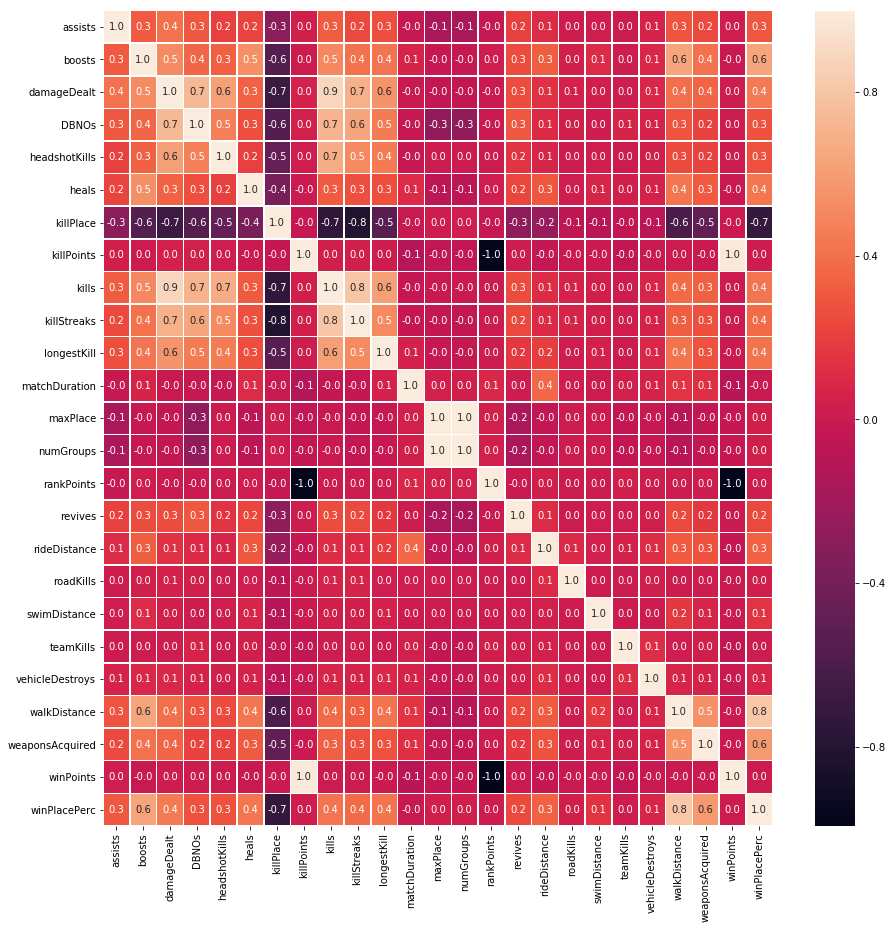

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 

f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

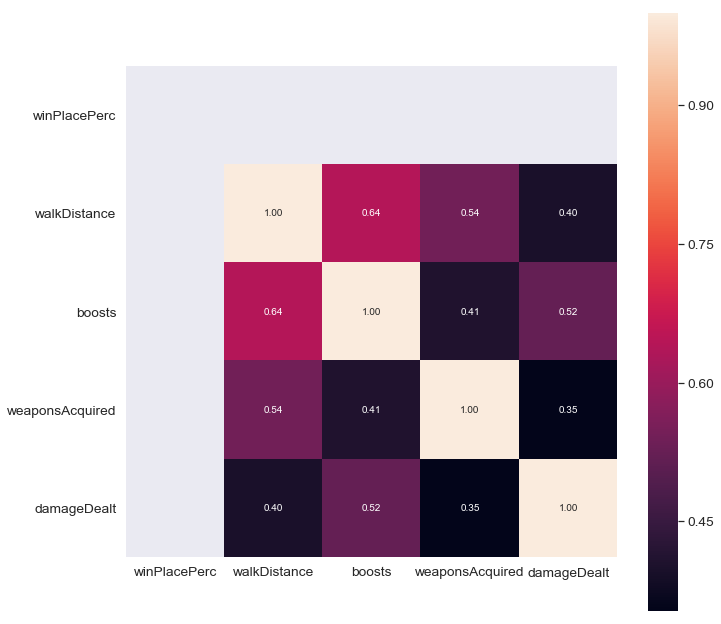

In [12]:
import numpy as np
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train_df.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
import os
assert os.system("pip install ultimate==2.15.1")==0

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing

from ultimate.mlp import MLP 
import gc, sys
gc.enable()

In [ ]:
NUM = 0

def feature_engineering(is_train=True):
    if is_train: 
        print("processing train.csv")
        df = train_df

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = test_df
    
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    if NUM > 0: df = df[:NUM]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")
    
    y = None
    
    print("get target")
    if is_train: 
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = np.array(df_out, dtype=np.float64)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names

In [ ]:
x_train, y, feature_names = feature_engineering(True)
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=False).fit(x_train)

print("x_train", x_train.shape, x_train.max(), x_train.min())
scaler.transform(x_train)
print("x_train", x_train.shape, x_train.max(), x_train.min())

y = y * 2 - 1
print("y", y.shape, y.max(), y.min())

In [ ]:
epoch_decay = 2
epoch_train = epoch_decay * 18
hidden_size = 32
mlp = MLP(
    layer_size = [x_train.shape[1], hidden_size, hidden_size, hidden_size, 1],
    activation = 'a2m2l',
    op='fc',

    # rate_init = 0.08, 
    # leaky = -0.2,
    rate_init = 0.06,   
    leaky = (5 ** 0.5 - 3) / 2,
    bias_rate = [], 
    regularization = 1,
    importance_mul = 0.0001, 
    output_shrink = 0.1, 
    output_range = [-1,1], 
    loss_type = "hardmse",
    verbose=1, 
    importance_out=True, iteration_log=20000, 
    rate_decay = 0.8, 
    epoch_train = epoch_train, 
    epoch_decay = epoch_decay,
)

In [ ]:
mlp.fit(x_train, y)
del x_train, y
gc.collect()

feature_importance = list(zip(feature_names, mlp.feature_importances_))
feature_importance.sort(key=lambda x:x[1], reverse=True)

print(feature_importance)

In [ ]:
x_test, _, _ = feature_engineering(False)
scaler.transform(x_test)
print("x_test", x_test.shape, x_test.max(), x_test.min())
np.clip(x_test, out=x_test, a_min=-1, a_max=1)
print("x_test", x_test.shape, x_test.max(), x_test.min())

In [ ]:
pred = mlp.predict(x_test)
del x_test
gc.collect()

In [ ]:
pred = pred.reshape(-1)
pred = (pred + 1) / 2

In [ ]:
if NUM > 0: test_df = test_df[:NUM]

print("fix winPlacePerc")
for i in range(len(test_df)):
    winPlacePerc = pred[i]
    maxPlace = int(test_df.iloc[i]['maxPlace'])
    if maxPlace == 0:
        winPlacePerc = 0.0
    elif maxPlace == 1:
        winPlacePerc = 1.0
    else:
        gap = 1.0 / (maxPlace - 1)
        winPlacePerc = round(winPlacePerc / gap) * gap
    
    if winPlacePerc < 0: winPlacePerc = 0.0
    if winPlacePerc > 1: winPlacePerc = 1.0    
    pred[i] = winPlacePerc

    if (i + 1) % 100000 == 0:
        print(i, flush=True, end=" ")

In [ ]:
test_df['winPlacePerc'] = pred

submission = test_df[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)